# Improve Your Workplace Using the Employee Review Analytics Engine

## Problem Definition

For company which is seeking to hire the best talent in the industry, it is important that it manages its workplace in a way that attracts the best talent. This requires the company to be on its toes to understand the expected requirements from a millennial generation that is highly talented and at the same time has little patience!. One of the best ways for the company to constantly improve and be the best place to work for, is to take the employee reviews seriously.  

However, the task is onerous because a lot of these reviews are highly subjective, biased, huge in number etc. All these facts lead to waste of precious energy in making strategic decisions that can help improve the work environment to help attract the best talent. 

The goal of this project is to implement an Analytics Engine that can aid companies in analyzing hundred or thousands of reviews that they receive periodically and provide decision support on what process or culture of the company needs to be improved upon, in order to make the company a great place to work.

A brief overview of the motivation and implementation can be found in this YouTube Video:
https://www.youtube.com/watch?v=f5ozOx5TE5M&rel=0

In [1]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from collections import Counter
import pandas as pd
import string
import numpy as np
import sklearn
import re
import scipy
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud,STOPWORDS
import itertools
from sklearn.cluster import KMeans
from collections import Counter
import sklearn.metrics.pairwise
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()
stopwords=nltk.corpus.stopwords.words('english')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dypna\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dypna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dypna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dypna\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Collection

We collected data across different industry type, company sizes and geographical location. Rating distribution was also an important criterion considered while collecting our data as it was important to have a balanced dataset for both excellent and poor company ratings. Our extraction script collects about 5000 reviews per company or whatever is available if a company has less. Our collected data can be considered semi-structure as it is a combination of numeric (e.g. Rating), True/False ( e.g. Recommend/Not Recommend) and pure text (e.g. Title, Pro, Cons) fields. The data also has a few missing fields that need to be treated during the Pre-processing Stage.

In summary, it was a well-balanced dataset strategically collected based on the stated criteria above and we believe this is very important in building a good model in our problem space. Overall we had close to 100,000 reviews for analysis.

#### Glassdoor Company Review Extraction Code

In [ ]:
import time
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from collections import namedtuple
import pandas as pd


# Read Glassdoor Username, Password and DriverPath from File
with open('GlassdoorUsernameAndPassword.txt') as f:
    Credential = [line.rstrip() for line in f]
username = Credential[0] # your email here
password = Credential[1] # your password here
chromDriverPath =  Credential[2] # chrome Driver Path here

#Initialize the default number of page. This get updated if the Review span over 5 pages
pages = 5

# Column Headers compName, companyURL
compdf = pd.read_csv("companyList.csv").values.tolist()

# Function to initialize the Chrome Web Driver  

def init_driver():
    chrome_options = Options()  
    chrome_options.add_argument("--headless") 
    driver = webdriver.Chrome(executable_path = chromDriverPath, chrome_options=chrome_options)
    driver.wait = WebDriverWait(driver, 10)
    return driver


# Function that that login to Glassdoor using the provided Credentials
def login(driver, username, password):
    driver.get("http://www.glassdoor.com/profile/login_input.htm")
    try:
        user_field = driver.wait.until(EC.presence_of_element_located(
            (By.NAME, "username")))
        pw_field = driver.wait.until(EC.presence_of_element_located(
            (By.NAME, "password")))
        login_button = driver.find_element_by_css_selector("button.gd-btn.gd-btn-1.fill") 
        user_field.send_keys(username)
        user_field.send_keys(Keys.TAB)
        time.sleep(1)
        pw_field.send_keys(password)
        time.sleep(1)
        login_button.click()
    except TimeoutException:
        print("TimeoutException! Username/password field or login button not found on glassdoor.com")


# Function that Parse the Glassdoor review page and extract relevant data
def parse_reviews_HTML(reviews, data):
    Review = namedtuple('Review', ['companyName', 'date', 'title', 'rating', 'role', 'recommends', 
                                   'outlook', 'approveCEO', 'length', 'pros', 'cons', 'advice2mgmt'])
    for review in reviews:
        length = ""
        recommends = ""
        positiveOutlook = ""
        approveCEO = ""
        advice2mgmt = ""
        date = ""
        companyName = compName
        dateCheck = review.find("time", { "class" : "date subtle small" })
        if (dateCheck):
            date = dateCheck.getText().strip()              
        role = review.find("span", { "class" : "authorJobTitle middle reviewer"}).getText().strip()
        title = review.find("span", { "class" : "summary"}).getText().strip()
        rating = review.find("span", { "class" : "value-title"})['title']
        
        outcomes = review.find_all("div", { "class" : ["tightLt", "col","span-1-3"] })
        if (len(outcomes) > 0):
            recommends = outcomes[0].find("span", { "class" : "middle"}).getText().strip()
        #endif
        if (len(outcomes) > 1):
            positiveOutlook = outcomes[1].find("span", { "class" : "middle"}).getText().strip()
        #endif
        if (len(outcomes) > 2):
            approveCEO = outcomes[2].find("span", { "class" : "showDesk"}).getText().strip()
            approveCEO = str(approveCEO)+ " CEO"
        #endif
        
        length = review.find("p", { "class" : ["tightBot", "mainText"]}).getText().strip()
        pros = review.select('p.pros.mainText.truncateThis.wrapToggleStr')[0].text
        cons = review.select('p.cons.mainText.truncateThis.wrapToggleStr')[0].text
        advice = review.select('p.adviceMgmt.mainText.truncateThis.wrapToggleStr')
        if (advice):
            advice2mgmt = advice[0].text

        r = Review(companyName, date, title, rating, role, recommends, positiveOutlook, approveCEO, 
                   length, pros, cons, advice2mgmt) 
        data.append(r)
    return data


# This function calls the parse_reviews_HTML function to extract relevant data for every review HTML
def get_data(driver, URL, startPage, endPage, data, refresh):
    if (startPage > endPage or endPage > 500 ): # Extract only top 500 pages if review is more than 500 pages
        return data

    currentURL = URL + "_P" + str(startPage) + ".htm"
    time.sleep(2)

    if (refresh):
        driver.get(currentURL)
        print ("Getting " + currentURL)

    time.sleep(2)
    HTML = driver.page_source
    soup = BeautifulSoup(HTML, "html.parser")
    reviews = soup.find_all("li", { "class" : ["empReview", "cf"] })

    end = soup.select('li.page.last')
    if (end):
        endPage = int(end[0].text)
        
    if (reviews):
        data = parse_reviews_HTML(reviews, data)
        print ("Page " + str(startPage) + " scraped.")
        if (startPage % 10 == 0):
            print ("\nTaking a breather for a few seconds ...")
            time.sleep(10)

        get_data(driver, URL, startPage + 1, endPage, data, True)
    else:
        print ("Waiting ... page still loading or CAPTCHA input required")
        time.sleep(3)
        get_data(driver, URL, startPage, endPage, data, False)

    return data

    
# Function that export to CSV.
def csv_export(data, compName):
    df = pd.DataFrame(data)
    filename = compName + ".csv"
    df.to_csv(filename, index=False, encoding='utf-8')
    
# Main Function that call all functions
if __name__ == "__main__":
    driver = init_driver()
    time.sleep(3)
    print ("Logging into Glassdoor account ...")
    login(driver, username, password)
    time.sleep(5)
    for compName,companyURL in compdf:
        print ("\nStarting data scraping ...")
        data = get_data(driver, companyURL[:-4], 1, pages, [], True)
        print ("\nDone with Extracting Data of " + compName )
        csv_export(data, compName)
    driver.quit()


In [ ]:
# Aggregate the CSV Files
import os
dname = "data/"
csv_paths = [dname+fname for fname in os.listdir(dname) if fname.endswith(".csv")]

fout=open("AllCompanyReviews.csv","a")
# first file:
for line in open(csv_paths[0], errors = "ignore"): 
    fout.write(line)
# now the rest:    
for i in range(1,len(csv_paths)):
    f = open(csv_paths[i],  errors = "ignore")
    next(f) #     f.next() # skip the header
    for line in f:
         fout.write(line)
    f.close() 
fout.close()

## Data Preparation and  Feature  Engineering

1. Load the data into the pandas data frame. 
2. Prepare the data by combining the "pros" and "cons" into a single "review" column.
3. Pre-process the "review" column to remove punctuation, tokenize and lemmatize it, in order to facilitate conversion into TF-IDF vector. 



In [2]:
# Load the data into data frame
df = pd.read_csv("AllCompanyReviews.csv",  encoding = "ISO-8859-1")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92999 entries, 0 to 92998
Data columns (total 12 columns):
companyName    92999 non-null object
date           92975 non-null object
title          92999 non-null object
rating         92999 non-null float64
role           92999 non-null object
recommends     80552 non-null object
outlook        75397 non-null object
approveCEO     59040 non-null object
length         92999 non-null object
pros           92999 non-null object
cons           92998 non-null object
advice2mgmt    57585 non-null object
dtypes: float64(1), object(11)
memory usage: 8.5+ MB


In [4]:
# combine the "Pros" and "Cons" into single "review" column
df['review'] = df['pros']+' '+ df['cons']

In [6]:
# Function to process the text from column into tokens 
# Reference from our own implementation of text classification in HW3
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ Normalizes case and handles punctuation
    Inputs:
        text: str: raw text
        lemmatizer: an instance of a class implementing the lemmatize() method
                    (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)
    Outputs:
        list(str): tokenized text
    """
    #convert the text to lower case
    text = str(text).lower()
    #replace ' and 's with empty string
    text = text.replace("'s","")
    text = text.replace("'","")
    #replace punctuation with white space
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    #split into tokens
    tokens = nltk.tokenize.word_tokenize(text)
    result = []
    for token in tokens:
        try:
            l_token = lemmatizer.lemmatize(token)
        except:
            continue
        else:
            result.append(str(l_token))
        
    return result
    pass

# Function to convert the entire "review" column in the dataframe into tokens with help of Process function. 
# Reference from our own implementation of text classification in HW3
def process_all(df, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ process all reviews in the dataframe using process function.
    Inputs
        df: pd.DataFrame: dataframe containing a column 'review'
        lemmatizer: an instance of a class implementing the lemmatize() method
                    (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)
    Outputs
        pd.DataFrame: dataframe in which the values of review column have been changed from str to list(str) containing tokenized words
    """
    df['review'] = df['review'].apply(process)
    return df
    pass

In [7]:
df = process_all(df)

#### Use SentimentIntensityAnalyzer library to extract the following features from review text:
1. Compund Score  [-1 , 1]
2. Positive Probability
3. Negative Probability
4. Neutral Probability

#### Use Textblob library to extract the following features from review text:
1. Polarity Score  [-1 , 1]
2. Subjectivity Score [0, 1]

In [8]:
# Get the additional features using SentimentIntensityAnalyzer and TextBlob library
sia_model = SentimentIntensityAnalyzer()
reviews = df.review.values
compound = []
negative = []
positive = []
neutral = []
subjectivity = []
polarity =[]
for review in reviews:
    text = " ".join(review)
    blob = TextBlob(text)
    scores = sia_model.polarity_scores(text)
    subjectivity.append(blob.sentiment.subjectivity)
    polarity.append(blob.sentiment.polarity)
    compound.append(scores['compound'])
    negative.append(scores['neg'])
    neutral.append(scores['neu'])
    positive.append(scores['pos'])

In [9]:
# create columns in data frame to include the additional features
df['compound_score'] = compound
df['prob_negative'] = negative
df['prob_neutral'] = neutral
df['prob_positive'] = positive
df['subjectivity_score'] = subjectivity
df['polarity_score'] = polarity
df = df.round(2)

In [10]:
df.columns

Index(['companyName', 'date', 'title', 'rating', 'role', 'recommends',
       'outlook', 'approveCEO', 'length', 'pros', 'cons', 'advice2mgmt',
       'review', 'compound_score', 'prob_negative', 'prob_neutral',
       'prob_positive', 'subjectivity_score', 'polarity_score'],
      dtype='object')

### Additional Data Preparation 
1. Remove non-relevent columns from the dataframe
2. Drop the rows with "NaN" values
3. Split the Data into Train and Test Sets.

In [11]:
# drop unwanted columns from the data
df_temp = df.drop([ 'date', 'title','length', 'pros', 'cons', 'advice2mgmt','role', 'recommends','outlook', 'approveCEO' ], axis = 1)

In [12]:
df_temp.columns

Index(['companyName', 'rating', 'review', 'compound_score', 'prob_negative',
       'prob_neutral', 'prob_positive', 'subjectivity_score',
       'polarity_score'],
      dtype='object')

In [14]:
# Remove rows with the "NaN" values
df_temp = df_temp.dropna(axis = 0, how = "any")

In [16]:
# Split the data into train and test data frames
df_train=df_temp.sample(frac=0.7,random_state=42)
df_test=df_temp.drop(df_train.index)

### Create TF-IDF Vectors for the Review Text

The next step is to derive TF-IDF feature vectors from the tokenized reviews. To reduce the number of words which are very large in number for the classification task, we omit the common " Stop Words" and " Rare Words". The "Stop Words" are those which occur very frequently and are of little value. The "Rare Words" are those which occur very rarely generally these words 
are typos. We take the " Stop Words" from the NLTK library. We implement a function to extract the "Rare Words".  We will consider a word  as " Rare" if it occurs not more than once in whole of corpus of tokenized reviews.


In [17]:
# Function to extract rare_words for TF-IDF creation
# Reference from our own implementation of text classification in HW3
def get_rare_words(df):
    """ 
    Inputs:
        pd.DataFrame
    Outputs:
        list(str): list of rare words, sorted alphabetically.
    """
    n = len(df.review)
    vocab = Counter()
    for row in df['review']:
        vocab.update(row)
    rare_words = []
    for word in vocab:
        if vocab[word] == 1:
            rare_words.append(word)
    return sorted(rare_words)
    pass

In [18]:
# Function to create TF-IDF features
# Reference from our own implementation of text classification in HW3
def create_features(df):
    """ 
    Inputs:
        pd.DataFrame
    Outputs:
        tfidf model and tfidf vector
    """
    stopwords=nltk.corpus.stopwords.words('english')
    stopwords_modified = [re.sub(r"('s)|(')","",word) for word in stopwords]
    rare_words = get_rare_words(df)
    tfidf = sklearn.feature_extraction.text.TfidfVectorizer(stop_words = stopwords_modified + rare_words)
    train = [' '.join(row) for row in df['review']]
    X = tfidf.fit_transform(train)
    return (tfidf,X)
    pass

In [19]:
# get the TF_IDF model and features after feeding train data
tfidf, X_train = create_features(df_train)

In [20]:
# Use the TF_IDF model in previous step to get the features for test data
test = [' '.join(row) for row in df_test['review']]
X_test = tfidf.transform(test)

In [21]:
# Extract the ratings for train and test data as y labels
y_train = df_train['rating'].values
y_test = df_test['rating'].values

In [22]:
df_train.columns

Index(['companyName', 'rating', 'review', 'compound_score', 'prob_negative',
       'prob_neutral', 'prob_positive', 'subjectivity_score',
       'polarity_score'],
      dtype='object')

In [23]:
X_train

<65099x20867 sparse matrix of type '<class 'numpy.float64'>'
	with 1735611 stored elements in Compressed Sparse Row format>

### Combine TF-IDF features with rest of the features in the dataframe
Now we combine the TF-IDF features with rest of the features in train and test data to create the necessary X-train and X_test to feed into model.

In [24]:
X_train = scipy.sparse.hstack([X_train,df_train.drop(['companyName', 'rating', 'review'], axis = 1)])
X_test = scipy.sparse.hstack([X_test,df_test.drop(['companyName', 'rating', 'review'], axis = 1)])

In [25]:
X_train

<65099x20873 sparse matrix of type '<class 'numpy.float64'>'
	with 2098633 stored elements in COOrdinate format>

In [26]:
X_test

<27900x20873 sparse matrix of type '<class 'numpy.float64'>'
	with 897655 stored elements in COOrdinate format>

## Modelling
 We built five classification models to predict the Rating:
 1. SVM 
 2. XgBoost Classifier
 3. Random Forest 
 4. Logistic Regression.
 5. AdaBoost Classifer
 
Out of these we selected the best 3 models to do Ensemble Model stacking with help of Logistic rgeression to determine weights for each classifier.

### SVM
Perform Grid Search to determine best parameters for SVM and fit the model on training data.

In [111]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

In [ ]:
svc = svm.SVC()
clf = GridSearchCV(svc, param_grid)
clf = clf.fit(df_train.as_matrix(), y_train)

In [ ]:
clf.best_estimator_

In [27]:
clf = svm.SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
              decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
              max_iter=-1, probability=False, random_state=None, shrinking=True,
              tol=0.001, verbose=False)
clf = clf.fit(X_train, y_train)

In [28]:
train_pred_svm = clf.predict(X_train)
test_pred_svm = clf.predict(X_test)
print(classification_report(y_test, test_pred_svm))

             precision    recall  f1-score   support

        1.0       0.53      0.53      0.53      3857
        2.0       0.32      0.26      0.28      4070
        3.0       0.36      0.40      0.38      6508
        4.0       0.42      0.45      0.43      7338
        5.0       0.57      0.51      0.54      6127

avg / total       0.44      0.44      0.44     27900



### Xgb classifier

In [29]:
clf = xgb.XGBClassifier()
clf = clf.fit(X_train, y_train)

In [30]:
train_pred_xgb = clf.predict(X_train)
test_pred_xgb = clf.predict(X_test)
print(classification_report(y_test, test_pred_xgb))

             precision    recall  f1-score   support

        1.0       0.50      0.48      0.49      3857
        2.0       0.34      0.11      0.16      4070
        3.0       0.33      0.33      0.33      6508
        4.0       0.37      0.56      0.45      7338
        5.0       0.52      0.46      0.48      6127

avg / total       0.41      0.41      0.39     27900



### RandomForest Classifier

In [31]:
clf = RandomForestClassifier()
clf = clf.fit(X_train, y_train)

In [32]:
train_pred_rf = clf.predict(X_train)
test_pred_rf = clf.predict(X_test)
print(classification_report(y_test, test_pred_rf))


             precision    recall  f1-score   support

        1.0       0.41      0.46      0.43      3857
        2.0       0.25      0.18      0.21      4070
        3.0       0.30      0.34      0.32      6508
        4.0       0.36      0.41      0.39      7338
        5.0       0.47      0.39      0.42      6127

avg / total       0.36      0.36      0.36     27900



### AdaBoost Classifier

In [33]:
clf = AdaBoostClassifier()
clf = clf.fit(X_train, y_train)

In [34]:
train_pred_ab = clf.predict(X_train)
test_pred_ab = clf.predict(X_test)
print(classification_report(y_test, test_pred_ab))

             precision    recall  f1-score   support

        1.0       0.45      0.51      0.48      3857
        2.0       0.33      0.11      0.16      4070
        3.0       0.32      0.34      0.33      6508
        4.0       0.37      0.48      0.42      7338
        5.0       0.49      0.45      0.47      6127

avg / total       0.39      0.39      0.38     27900



### LogisticRegression

In [35]:
clf = LogisticRegression( solver = 'saga', multi_class = 'multinomial')
clf = clf.fit(X_train, y_train)

In [36]:
train_pred_lr = clf.predict(X_train)
test_pred_lr = clf.predict(X_test)
print(classification_report(y_test, test_pred_lr))

             precision    recall  f1-score   support

        1.0       0.54      0.55      0.54      3857
        2.0       0.34      0.23      0.28      4070
        3.0       0.37      0.41      0.39      6508
        4.0       0.41      0.46      0.44      7338
        5.0       0.56      0.54      0.55      6127

avg / total       0.44      0.44      0.44     27900



## Ensemble and Model Stacking

After evaluating the relative performance of the 5 models,  we selected the best 3 models given below  to do Ensemble Model stacking with help of Logistic regeression to determine weights for each classifier.

 1. SVM 
 2. XgBoost Classifier
 3. Logistic Regression.


In [ ]:
# combine the train and test prediction s of the three models into single matrix
X_train = np.vstack((train_pred_svm, train_pred_lr, train_pred_ab, train_pred_xgb)).T
X_test = np.vstack((test_pred_svm, test_pred_lr, test_pred_ab, test_pred_xgb)).T

In [43]:
# Use logisitc regression to perform ensemble model stacking
clf = LogisticRegression( solver = 'saga', multi_class = 'multinomial')
clf = clf.fit(X_train, y_train)

In [44]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        1.0       0.52      0.56      0.54      3857
        2.0       0.34      0.18      0.24      4070
        3.0       0.36      0.43      0.39      6508
        4.0       0.42      0.46      0.44      7338
        5.0       0.57      0.52      0.55      6127

avg / total       0.44      0.44      0.44     27900



## Final Result with Rating and Subjectivity scores for Test data
Now we create the Final Result containing 
1. "Rating" predicted by the Ensemble model on test data 
2. "Subjectivity_Score" using TextBlob Library on the test data. 

In [101]:
reviews = df_test.review.values
subjectivity = []
review_joined = []
for review in reviews:
    text = " ".join(review)
    blob = TextBlob(text)
    review_joined.append(text)
    subjectivity.append(int(blob.sentiment.subjectivity*100))

In [104]:
df_result = pd.DataFrame(np.column_stack([review_joined, y_pred.tolist(), subjectivity]), 
                               columns=['Review', 'Rating', 'Subjectivity_Score %'])

In [107]:
df_result.head(10)


,Review,Rating,Subjectivity_Score %
0,reward competition and drive with opportunity ...,5.0,37
1,free gym membershippotential to make a lot of ...,1.0,65
2,this job wa amazing it wa tough because it wa ...,4.0,65
3,flexible schedulegreat for student facility wa...,3.0,60
4,offered great training and continuing educatio...,5.0,85
5,they were flexible with my hour considering i ...,3.0,42
6,flexible schedule plenty of room and opportuni...,3.0,60
7,free gym pas flexible hour dirty smelly enviro...,3.0,63
8,flexible schedule career growth personal profe...,5.0,20
9,good group exercise class selection some locke...,3.0,55


## Identify Focus Areas 

From the above final result we can help the company identify the focus areas for improvement by creating the word clouds. To generate meaningful word clouds it is important that the "review" text used for the clouds are objective enough to derive useful conclusions. This is important as most of reviews are highly subjective and emotional without giving any reasons given by the employee for their high or low rating. By choosing only reviews which have "Subjectivity_Score" < 50% for generating word cloud, we make the overall analysis much more objective deriving value for  company and help drive improvements in work place especially from negative reviews.

We create two word clouds here:
1. Indentify areas where the company is already good at, by selecting objective reviews with "Subjectivity_Score" < 50% and rating > 3. This is "Positive" word cloud in white background.

2. Indentify areas where the company is needs to improve at, by selecting objective reviews with "Subjectivity_Score" < 50% and rating < 3. This is "Negative" word cloud in black background.



In [71]:
# get the stop words and rare words to exclude from the word cloud
stopwords_modified = [re.sub(r"('s)|(')","",word) for word in stopwords]
rare_words = get_rare_words(df_temp)

In [72]:
df_test['rating'] = y_pred

In [73]:
# select the positive and negative reviews based on the criteria described above
positive = df_test[(df_test['subjectivity_score'] < 0.5) & (df_test['rating'] > 3.0)]['review'].values
negative = df_test[(df_test['subjectivity_score'] < 0.5) & (df_test['rating'] < 3.0)]['review'].values

In [81]:
# Fuction to draw the word cloud using the WordCloud library
def wordcloud_draw(data, color):
    data = list(itertools.chain.from_iterable(list(data)))
    joined_data = " ".join(data)
    wordcloud = WordCloud(stopwords= stopwords_modified + rare_words+ ["wa", "lot", "company", "get", "employee", "ha"],
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(joined_data)
    plt.figure(1,figsize=(15, 15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

Positive words


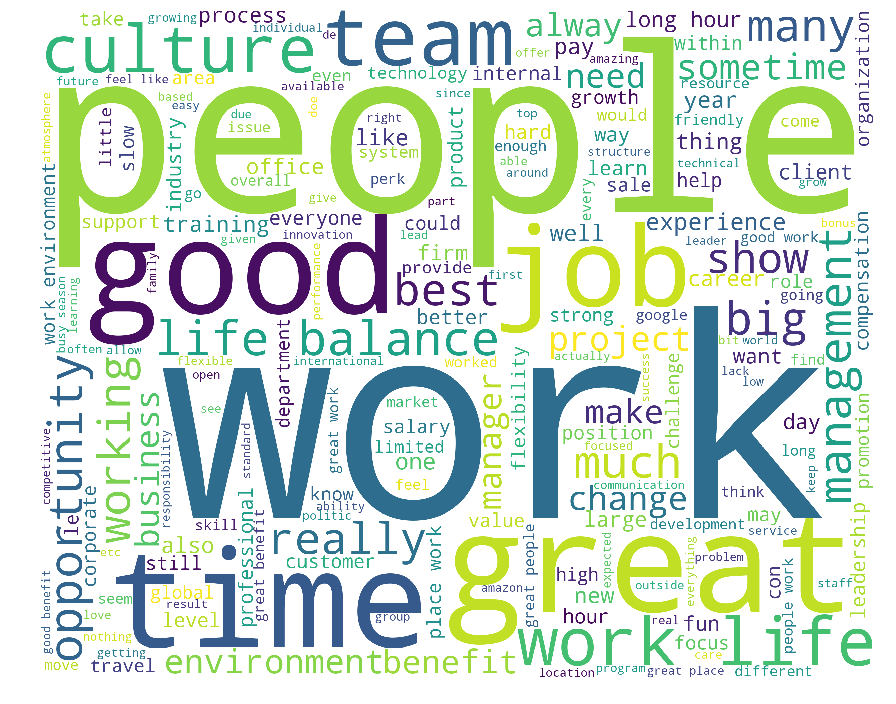

Negative words


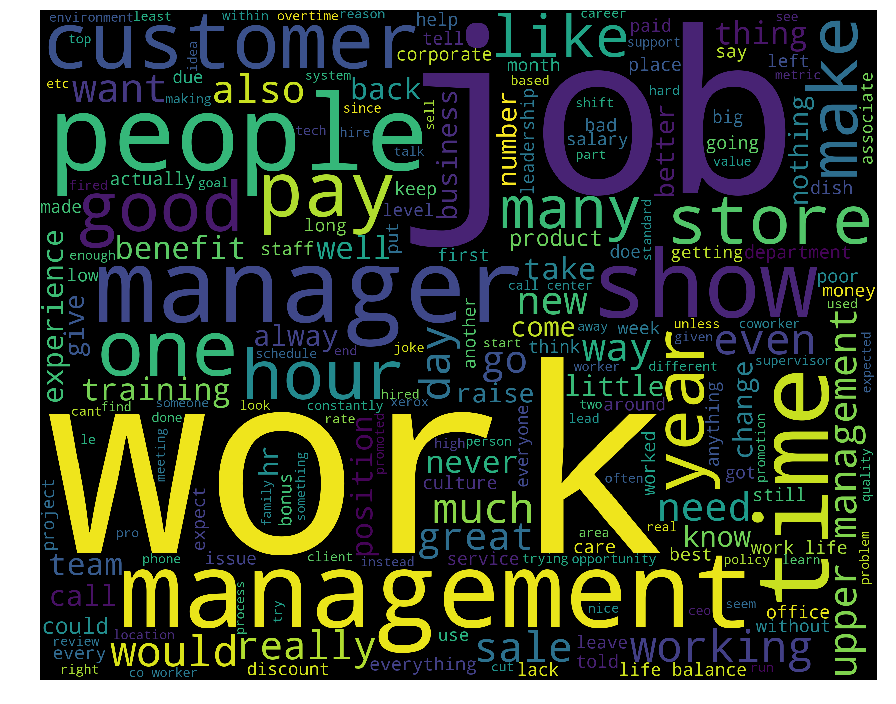

In [82]:
print("Positive words")
wordcloud_draw(positive,'white')
print("Negative words")
wordcloud_draw(negative, 'black')

# References
1. https://programminghistorian.org/lessons/sentiment-analysis for using SentimentIntensityAnalyzer from NLTK.
2. https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/ for using TextBlob library
3. https://amueller.github.io/word_cloud/ for using WordCloud library.
